In [5]:
from pyspark import SparkContext
import json

if SparkContext._active_spark_context is None:
    sc = SparkContext("local", "WordCount")
else:
    sc = SparkContext.getOrCreate()

file_content = sc.textFile("data/textFiles/tokens_clean.txt").collect()

joined_content = ''.join(file_content)

json_acceptable_string = joined_content.replace("'", "\"")
content = json.loads(json_acceptable_string)
print(type(content))  

total_words = []

for key in content.keys():
    for caption in content[key]:
        total_words.extend(caption.split())

total_word_count = len(total_words)
print("Total Words = %d" % total_word_count)




<class 'dict'>
Total Words = 1955246


In [6]:

words_rdd = sc.parallelize(total_words)

word_freq_rdd = words_rdd.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

word_freq = dict(word_freq_rdd.collect())

print("Number of unique words = " + str(len(word_freq.keys())))

24/10/29 15:18:25 WARN TaskSetManager: Stage 8 contains a task of very large size (13112 KiB). The maximum recommended task size is 1000 KiB.


Number of unique words = 18079


In [7]:
word_freq_rdd = words_rdd.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)

sorted_freq_rdd = word_freq_rdd.sortBy(lambda x: x[1], ascending=False)

threshold = 10

filtered_words_rdd = sorted_freq_rdd.filter(lambda x: x[1] > threshold)

sorted_freq_cnt = filtered_words_rdd.collect()

total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

sc.stop()

24/10/29 15:18:28 WARN TaskSetManager: Stage 10 contains a task of very large size (13112 KiB). The maximum recommended task size is 1000 KiB.


Number of common unique words = 5136


PREPARE TRAIN AND TEST DATA

In [17]:

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/flickr30k_train.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/flickr30k_test.txt", 'r') as file:
    test_file_data = file.read()

In [18]:
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [19]:
train_data[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [20]:

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [21]:
train_content['1001896054']

['startseq a man with reflective safety clothes and ear protection drives a john deere tractor on a road  endseq',
 'startseq john deere tractors cruises down a street while the driver wears easy to see clothing  endseq',
 'startseq a man in a neon green and orange uniform is driving on a green tractor  endseq',
 'startseq a man in a tractor wearing headphones driving down a paved street  endseq',
 'startseq a man driving a john deere tractor on a main road in the country  endseq']

EXTRACT FEATURES FROM IMAGES USING RESNET50 ARCHIECTURE

In [22]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

In [23]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68000030517578..151.06100463867188].


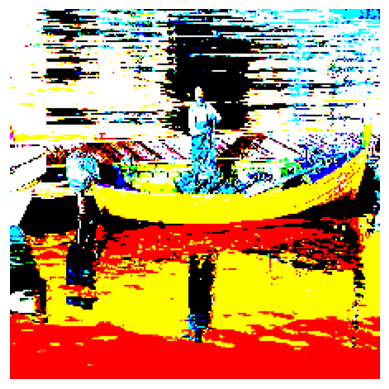

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
from keras.models import Model
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from time import time

spark = SparkSession.builder.appName("ImagePreprocessing").getOrCreate()

model_new = Model(model.input, model.layers[-2].output)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)

    img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)

    return img

preprocess_udf = udf(lambda path: preprocess_image(path).flatten().tolist(), ArrayType(FloatType()))

image_paths = ["data/Images/flickr30k_images/flickr30k_images/4376178.jpg"]
df = spark.createDataFrame([(path,) for path in image_paths], ["image_path"])

preprocessed_images_df = df.withColumn("preprocessed_image", preprocess_udf("image_path"))

preprocessed_images = preprocessed_images_df.collect()
for row in preprocessed_images:
    img_array = np.array(row['preprocessed_image']).reshape(1, 224, 224, 3) 
    plt.imshow(img_array[0])
    plt.axis('off')
    plt.show()

spark.stop()

In [25]:
def encode_image(img_path):
    img = preprocess_image(img_path)  
    feature_vector = model_new.predict(img)  

    feature_vector = feature_vector.reshape((-1,))  
    return feature_vector


In [26]:
train_encoding = {}
start_time = time()

for index, imageID in enumerate(train_data):
    image_path = f"data/Images/flickr30k_images/flickr30k_images/{imageID}.jpg"
    
    try:
        train_encoding[imageID] = encode_image(image_path)
    except Exception as e:
        print(f"Error encoding image {imageID}: {e}")

    if index % 100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time - start_time, "sec")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Encoding in progress... STEP 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━

In [27]:

import pickle

with open("encoded_train_features.pkl", "wb") as file:
    pickle.dump(train_encoding, file)

In [28]:
test_encoding = {}

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/flickr30k_images/flickr30k_images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Encoding in progress... STEP 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━

In [29]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

PREPROCESS THE CAPTIONS

In [30]:
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [31]:
print(len(index_to_word))

5136


In [32]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [33]:
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [34]:
print(VOCAB_SIZE)

5139


In [35]:
import pickle
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [36]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [37]:
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [38]:
print(max_len)

80


In [39]:

file = open("data/textFiles/glove.6B.50d.txt",encoding='utf8')

In [40]:
with open("data/textFiles/glove.6B.50d.txt", encoding='utf8') as file:
    embeddings_index = {}  

    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float')
        embeddings_index[word] = coefs

print(embeddings_index["apple"])


[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


In [41]:
embeddings_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [42]:
embedding_dim = 50

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [43]:
embedding_matrix.shape

(5139, 50)

DEFINE MODEL ARCHITECTURE

In [44]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM


inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [45]:

inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [46]:
from keras.layers import add


decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)




In [47]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 50)    │    256,950 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 80)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5139)      │  1,320,723 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,482,377 (9.47 MB)

 Trainable params: 2,482,377 (9.47 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [50]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

TRAIN THE MODEL

In [51]:
epochs = 15
batch_size = 5
steps = len(train_content)//batch_size

In [52]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator(train_content, train_encoding, word_to_index, max_len, batch_size, VOCAB_SIZE):
    while True:
        X1, X2, y = [], [], []
        for imageID, cap_list in train_content.items():
            image = train_encoding[imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range(1, len(idx_seq)):
                    xi = idx_seq[:i]  
                    yi = idx_seq[i]   

                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                    if len(X1) == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []

output_signature = (
    (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32), tf.TensorSpec(shape=(None, None), dtype=tf.float32)),
    tf.TensorSpec(shape=(None, VOCAB_SIZE), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_content, train_encoding, word_to_index, max_len, batch_size, VOCAB_SIZE),
    output_signature=output_signature
)

for i in range(epochs):
    model.fit(train_dataset, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 224s 38ms/step - loss: 5.4965


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 238s 41ms/step - loss: 4.4002


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 251s 43ms/step - loss: 4.0288


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 263s 45ms/step - loss: 3.7879


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 270s 47ms/step - loss: 3.5945


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 274s 47ms/step - loss: 3.4325


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 258s 44ms/step - loss: 3.2852


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 262s 45ms/step - loss: 3.1834


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 274s 47ms/step - loss: 3.0614


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 281s 48ms/step - loss: 2.9599


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 264s 45ms/step - loss: 2.8646


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 256s 44ms/step - loss: 2.7973


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 255s 44ms/step - loss: 2.7132


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 243s 42ms/step - loss: 2.6502


5800/5800 ━━━━━━━━━━━━━━━━━━━━ 255s 44ms/step - loss: 2.6017


In [53]:
model.load_weights('./model_14.h5')

In [54]:
images = './data/Images/flickr30k_images/flickr30k_images/'

In [55]:
from pickle import dump, load
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [56]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [61]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [62]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

['the man with pierced ears is wearing glasses and an orange hat ',
 'a man with glasses is wearing a beer can crocheted hat ',
 'a man with gauges and glasses is wearing a blitz hat ',
 'a man in an orange hat starring at something ',
 'a man wears an orange hat and glasses ']

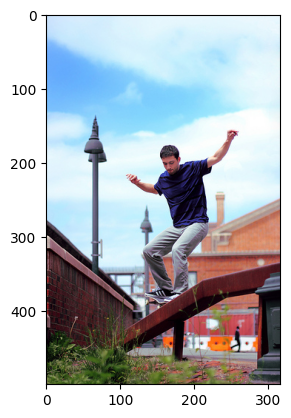

Generated Caption: a man in a blue shirt and jeans grinds down a rail on his skateboard 
Image ID: 7292785488


In [68]:
import random
import matplotlib.pyplot as plt

z = random.randint(0, len(encoding_test) - 1)  
pic = list(encoding_test.keys())[z]  
test_content[pic]


reference = test_content[pic]
e = encoding_test[pic].reshape(1,2048)
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
caption = greedySearch(e)
print("Generated Caption:",caption)
print()
print('Image ID:', pic)


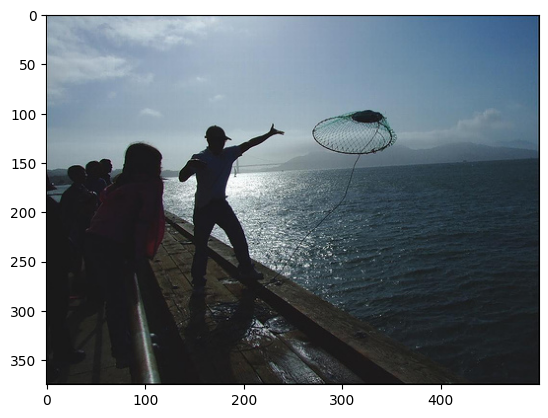

Generated Caption: a man throws a net off of a boat while children watch 
Image ID: 566945636


In [69]:
import random
import matplotlib.pyplot as plt

z = random.randint(0, len(encoding_test) - 1)  
pic = list(encoding_test.keys())[z]  
test_content[pic]


reference = test_content[pic]
e = encoding_test[pic].reshape(1,2048)
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
caption = greedySearch(e)
print("Generated Caption:",caption)
print()
print('Image ID:', pic)


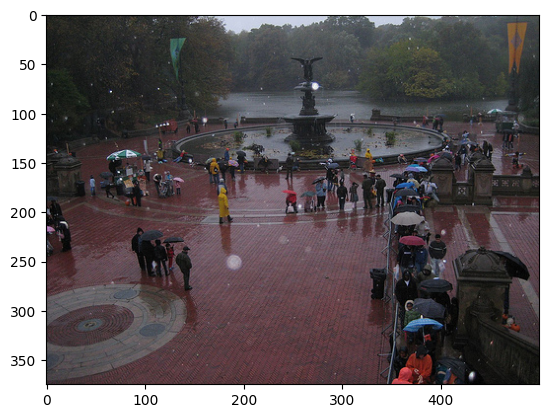

Generated Caption: people gathering near a fountain while it snows 
Image ID: 3192267612


In [70]:
import random
import matplotlib.pyplot as plt

z = random.randint(0, len(encoding_test) - 1)  
pic = list(encoding_test.keys())[z]  
test_content[pic]


reference = test_content[pic]
e = encoding_test[pic].reshape(1,2048)
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
caption = greedySearch(e)
print("Generated Caption:",caption)
print()
print('Image ID:', pic)


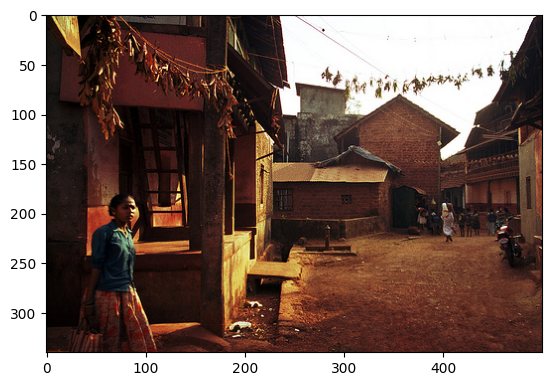

Generated Caption: little town and its people on the streets 
Image ID: 4095309334


In [71]:
import random
import matplotlib.pyplot as plt

z = random.randint(0, len(encoding_test) - 1)  
pic = list(encoding_test.keys())[z]  
test_content[pic]


reference = test_content[pic]
e = encoding_test[pic].reshape(1,2048)
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
caption = greedySearch(e)
print("Generated Caption:",caption)
print()
print('Image ID:', pic)
